In [2]:
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [94]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re
from html.parser import HTMLParser
import nltk
from nltk import sent_tokenize, word_tokenize
from nltk.tokenize import RegexpTokenizer
from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer
from nltk.stem import WordNetLemmatizer
import string

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics.pairwise import cosine_similarity
nltk.download('stopwords')
nltk.download('punkt')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [0]:
stop_words = set(stopwords.words('english')) 
punct = set(string.punctuation)
stemmer = PorterStemmer()

def text_cleaning(text):
    # converting HTML character codes to ASCII code
    parser = HTMLParser()
    text =  parser.unescape(text)
    
    text = re.sub(r'<[^>]+>','',text) # removing HTML tags
    text = re.sub(r'(?:\#+[\w_]+[\w\'_\-]*[\w_]+)','',text) # removing hash-tags
    text = re.sub(r'http[s]?://(?:[a-z]|[0-9]|[$-_@.&amp;+]|[!*\(\),]|(?:%[0-9a-f][0-9a-f]))+','',text) # removing URLs
    text = re.sub(r'(?:[\ufffd]+)','',text) #removing special characters
    text = ''.join(word for word in text if word not in punct) #remove punctuation
    text = re.sub('\n',' ',text) #remove new line
    text = re.sub('@','',text) #remove @ sign
    text = re.sub('’','',text)
    text = text.lower() # lowercase all characters
    text = word_tokenize(text) # tonkenize words
    text = [i for i in text if not i in stop_words] #remove stop words
    #text = [stemmer.stem(word) for word in text]
    text = ' '.join(text)
    
    return text


In [0]:
df_1 = pd.read_csv('/content/gdrive/My Drive/Amazon Seller Forum/cleaned_comments.csv') # Gabriel's cleaned comments
df_2 = pd.read_csv('/content/gdrive/My Drive/Amazon Seller Forum/Amazon_Forum_scrape2.csv',encoding= 'unicode_escape') # Wei Huang's comments

In [97]:
# Cleaning df_1
df_1.drop(['Unnamed: 0','Link'],axis=1,inplace=True)
df_1['Title'] = df_1['Title'].apply(lambda x: text_cleaning(x))
df_1['Reply Authors'] = df_1['Reply Authors'].apply(lambda x: word_tokenize(x))
df_1['Reply Authors'] = df_1['Reply Authors'].apply(lambda x: [word for word in x if word not in punct])
df_1['Reply Authors'] = df_1['Reply Authors'].apply(lambda x: [re.sub('\'','',x[i]) for i in range(len(x))])

# Cleaning df_2
df_2.drop('Unnamed: 0',axis=1,inplace=True)
df_2.dropna(axis=0,inplace=True)
df_2['Topic Title'] = df_2['Topic Title'].apply(lambda x: text_cleaning(x))
df_2['Category'] = df_2['Category'].apply(lambda x: x.strip())

df_2['Authors'] = df_2['Authors'].apply(lambda x: word_tokenize(x))
df_2['Authors'] = df_2['Authors'].apply(lambda x: [word for word in x if word not in punct])
df_2['Authors'] = df_2['Authors'].apply(lambda x: [re.sub('\'','',x[i]) for i in range(len(x))])
df_2['Reply Authors'] = df_2['Authors'].apply(lambda x: x[1:])
df_2['Authors'] = df_2['Authors'].apply(lambda x: x[0])

df_2['Leading Comment'] = df_2['Leading Comment'].apply(lambda x: text_cleaning(x))
df_2['Other Comments'] = df_2['Other Comments'].apply(lambda x: text_cleaning(x))
df_2.rename(columns={'Topic Title':'Title','Authors':'Post Author','Other Comments':'Reply Comments'},inplace=True)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:8: DeprecationWarning: The unescape method is deprecated and will be removed in 3.5, use html.unescape() instead.
  


In [0]:
df = pd.concat([df_1[['Title','Category','Post Author','Reply Authors','Leading Comment','Reply Comments']],
                df_2[['Title','Category','Post Author','Reply Authors','Leading Comment','Reply Comments']]],axis=0)
df['num_Reply_Authors'] = df['Reply Authors'].apply(lambda x: len(x))
#df.drop_duplicates(keep='first',inplace=True)
df.reset_index(drop=True,inplace=True)

## Exploratory Analysis

In [99]:
print('Users with most posts published')
pd.DataFrame(df.groupby('Post Author')['Title'].count().sort_values(ascending=False).head(10))

Users with most posts published


,Title
Post Author,
Rick_MWS,22
Superior_Home_Busine,15
austin_w_lwa,13
dzp1,11
SD_Ca,10
westland_print,10
CKZ,8
csteve,8
liw48,8


In [100]:
print('Category with most posts published')
pd.DataFrame(df.groupby('Category')['Title'].count().sort_values(ascending=False))

Category with most posts published


,Title
Category,
Selling on Amazon,2127
Fulfillment By Amazon,1500
Account Health,1475
Amazon Pay,630
Global Selling,600
Groups,520
Amazon Sponsored Products,330
Amazon Marketplace Web Service (MWS),330
Amazon Custom,302


In [101]:
for cat in df['Category'].unique():
  titles = df[df['Category']== cat]['Title']
  tfidf_vectorizer = TfidfVectorizer(max_df=0.5,
                                     max_features=20,
                                     stop_words='english',
                                     use_idf=True,
                                     ngram_range=(2,3))
  tfidf_matrix = tfidf_vectorizer.fit_transform(titles)
  terms = tfidf_vectorizer.get_feature_names()

  print('The top 10 key words in post title from the category: ', cat)
  print(terms)
  print('\n')

The top 10 key words in post title from the category:  Fulfillment By Amazon
['amazon fba', 'channel fulfillment', 'deleting inventory receiving', 'fba inventory', 'fba order', 'fba returns', 'fba shipment', 'fba shipments', 'fba warehouse', 'fulfillment order', 'inventory receiving', 'inventory receiving whsxfr', 'multi channel', 'multi channel fulfillment', 'multichannel fulfillment', 'receiving whsxfr', 'removal order', 'seller support', 'small light', 'stranded inventory']


The top 10 key words in post title from the category:  Selling on Amazon
['3rd party', 'account suspended', 'amazon account', 'amazon seller', 'amazon seller app', 'app working', 'brand registry', 'buy box', 'buy shipping', 'credit card', 'gtin exemption', 'mobile app', 'need help', 'new seller', 'seller account', 'seller app', 'seller central', 'seller support', 'selling canada', 'shipping label']


The top 10 key words in post title from the category:  Amazon Marketplace Web Service (MWS)
['access mws', 'amaz

In [81]:
for cat in df['Category'].unique():
  comments = df[df['Category']== cat]['Leading Comment']
  tfidf_vectorizer = TfidfVectorizer(max_df=0.5,
                                     max_features=20,
                                     stop_words='english',
                                     use_idf=True,
                                     ngram_range=(2,3))
  tfidf_matrix = tfidf_vectorizer.fit_transform(comments)
  terms = tfidf_vectorizer.get_feature_names()

  print('The top 10 key words in leading comments from the category: ', cat)
  print(terms)
  print('\n')

The top 10 key words in leading comments from the category:  Fulfillment By Amazon
['30 days', 'amazon fba', 'amazon seller', 'amazon warehouse', 'customer service', 'dont know', 'fba inventory', 'fba shipment', 'fulfillment center', 'fulfillment centers', 'fulfillment order', 'lead item', 'multichannel fulfillment', 'receipts entry', 'removal order', 'seller central', 'seller support', 'selling amazon', 'shipping plan', 'thanks advance']


The top 10 key words in leading comments from the category:  Selling on Amazon
['account health', 'amazon seller', 'amazon seller app', 'bank account', 'brand registry', 'buy box', 'buy shipping', 'credit card', 'dont know', 'dont want', 'make sure', 'new product', 'new seller', 'sell amazon', 'seller account', 'seller app', 'seller central', 'seller support', 'selling amazon', 'thanks advance']


The top 10 key words in leading comments from the category:  Amazon Marketplace Web Service (MWS)
['access amazon', 'affected change', 'amazon information

In [82]:
print('Top 10 authors with most amount of replys')
pd.DataFrame(df.groupby(['Category','Post Author'],
                        as_index=False)['num_Reply_Authors'].sum()).\
                        sort_values(by='num_Reply_Authors',ascending=False).head(10)

Top 10 authors with most amount of replys


,Category,Post Author,num_Reply_Authors
4861,Groups,Superior_Home_Busine,109
1114,Account Health,dzp1,67
1712,Amazon Marketplace Web Service (MWS),Rick_MWS,62
4755,Groups,John_C_Lipham_Constr,52
6876,Selling on Amazon,josephm,51
1467,Amazon Custom,bendztek,47
4835,Groups,Real_Computers,47
3833,Fulfillment By Amazon,jimnew,47
1733,Amazon Marketplace Web Service (MWS),The42ndStreet,46
4941,Groups,hd_property_services,45


(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10]),
 <a list of 11 Text major ticklabel objects>)

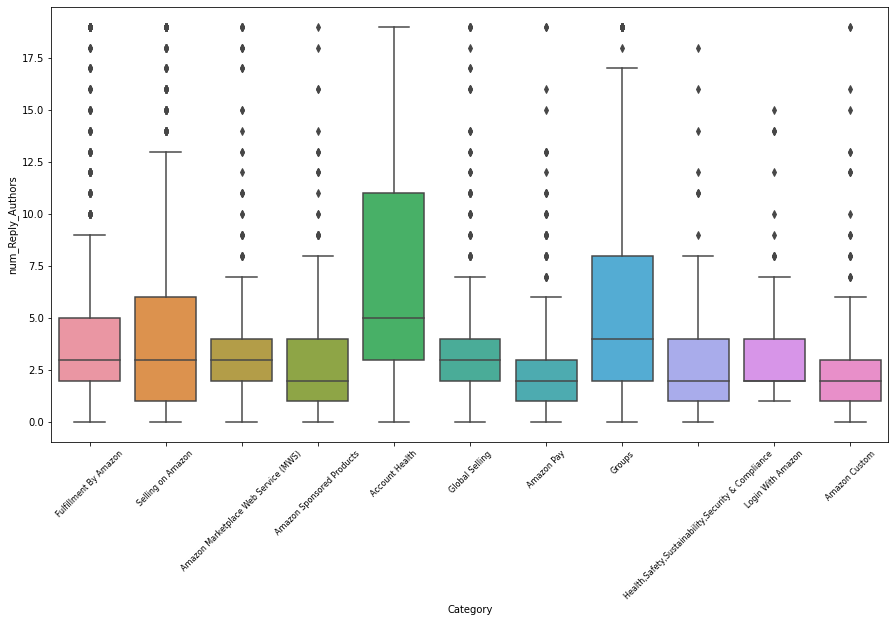

In [93]:
fig= plt.figure(figsize=(15,8))
ax = fig.add_subplot(111)
ax = sns.boxplot(x='Category',y='num_Reply_Authors',data=df)
plt.xticks(fontsize=8,rotation=45)

<p style="color:blue">Great idea using boxplots but I don't understand what insights you derived from them here.
We usually use them to understand the distribution of the data. But more importantly to discover Outliers and try to deal with them. If you used it to discover outliers it would have been interesting to investigate wat those gray points are all about. Like are there some errors that can be fixed, etc</p>

## Get similar comments based on cosine similarity method 

In [0]:
def get_top_comments(docu_list, n, labels):
    #Given a list of comments, find the indices with the highest n values.
    #Return the labels for each of these indices.
    return [labels[i] for i in np.argsort(docu_list)[::-1][:n]]  

In [122]:
vectorizer = TfidfVectorizer(analyzer = 'word', 
                             stop_words = 'english', 
                             lowercase = True, 
                             max_features = 5000)

documents = df['Leading Comment']

documents_vec = vectorizer.fit_transform(documents).toarray()

words = vectorizer.get_feature_names()

random_comment = np.random.choice(documents, 1)

random_comment_vec = vectorizer.transform([random_comment[0]]).toarray()
# Calculate the similarity score(s) between vector(s) and training vectors
similarity_score = cosine_similarity(random_comment_vec, documents_vec)

# top 5 similar comments
# because the 1st comment is the randomly selected one, n should be set as n+1
n = 5+1
similar_comments = get_top_comments(similarity_score[0], n, list(documents))

print('The randomly selected comment: \n%s\n' % (random_comment[0]))
print('---Top %s similar comments---' % (n-1))
print('')

for i in range(1,n):
    print('No. %d similar comment is: \n %s.\n' % (i, similar_comments[i]))

The randomly selected comment: 
greetings sent shipment numerous cases amazon via ups partner carrier two cases got lost transit nov 22 contacted amazon support numbers times response keep getting amazon support eligible investigation since boxes checked yet never get checked since ups lost two cases know covered fba lost damaged reimbursement policy submit get reimbursed since response keep getting amazon support eligible investigation thank advance help

---Top 5 similar comments---

No. 1 similar comment is: 
 need help community creating cases amazon seller support getting anywhere refusing help facts situation include 13 boxes product sent via ups tracking numbers 1z81rf430300429193 1z81rf430302377405 1z81rf430301857817 1z81rf430325274429 1z81rf430300311238 1z81rf430305532240 1z81rf430341981456 1z81rf430316782861 1z81rf430328740473 1z81rf430345938282 1z81rf430315340296 1z81rf430344390508 1z81rf430344612910 tracking numbers show boxes delivered amazon successfully receive two boxes

## Analaysis with Count Vectorizer

In [0]:
#First we initialize the count vectorizer
cvec = CountVectorizer(stop_words='english')
#cvec = CountVectorizer()

#then we combine all the comments from a forum post concatenating title, leading comment and reply comment
df['All Text'] =  df['Title'] + " "+ df['Leading Comment'] + " "+ df['Reply Comments']

#Now we apply count vectorizer to this elements in this column
sparse_matrix = cvec.fit_transform(df['All Text'])

#the resulting 2D matrix is D documents x n words long

doc_term_matrix = sparse_matrix.todense()
cv_df = pd.DataFrame(doc_term_matrix, columns = cvec.get_feature_names(), index = df['Title'])
#sim_arr = cosine_similarity(cv_df, cv_df)

In [0]:
for cat in df['Category'].unique():
  text = df[df['Category']== cat]['All Text']
  count_vectorizer = CountVectorizer(max_df=0.3,
                                     stop_words='english',
                                     )
  cvec_matrix = count_vectorizer.fit_transform(text)
  terms = count_vectorizer.get_feature_names()

  print('The top 10 key words in post title from the category: ', cat)
  print(terms)
  print('\n')

<p style="color:red">Remarks:</p>

- When using visualizations it is advised to accompaign them with a small paragraph or statement explaining what they are about so that people can understand what was the purpose of the analyst from drawing their attention to those points.
- After data cleaning the most important step for a data scientist is visualizing and understanding their data. So it would have been advantageous to explore the data more. This exploration, helps not only to detect noise in the data but also understand and debug the results of the ML models.